In [268]:
try:
    import transformer_lens
except:
    %pip install git+https://github.com/neelnanda-io/TransformerLens
    %pip install circuitsvis

In [269]:
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt

from jaxtyping import Float
from functools import partial

In [270]:
DEVICE = 'cuda'

In [271]:
# TODO: scale up model, it's struggling to learn
N_CTX = 128
D_VOCAB = 11 # 10 digits and a comma
cfg = transformer_lens.HookedTransformerConfig(
    n_layers=1,
    d_model=128,
    n_ctx=N_CTX,
    d_head=32,
    n_heads=1,
    d_mlp=None,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=True,
)
model = transformer_lens.HookedTransformer(cfg, move_to_device=True)

In [272]:
# data generation
from torch.utils.data import DataLoader, TensorDataset

def fib_sequence(seq_length: int, a=0, b=1) -> np.ndarray:
    output = [a, b]
    while len(output) < seq_length:
        output.append(output[-2] + output[-1])
    for x in reversed(output):
        if x > 9_223_372_036_854_775_808:
            print("Warning large num", a, b, x)
        else:
            break
    return np.array(output)


def tokenize(c: str):
    return ord(c) - ord("0") if c.isdigit() else 10  # 10 is comma


def untokenize(toks) -> str:
    return "".join([chr(tok + ord("0")) if tok < 10 else "," for tok in toks])


def seq_to_tokens(seq: np.ndarray) -> torch.Tensor:
    seq_str = ",".join(seq.astype(str))
    return torch.tensor([tokenize(c) for c in seq_str], device=DEVICE)


def generate_data(sequences: np.ndarray):
    # generates x,y items from sequences
    X, y = [], []
    for seq in sequences:
        # This could be a suboptimal way to do it but we're just showing it the next digit.
        # e.g. for x = 1,1,2,3,5,8,12, y=2 (rather than 20)
        tokens = seq_to_tokens(seq)
        x_width = cfg.n_ctx
        if len(tokens) < x_width + 1:
            raise Exception(len(tokens))
        
        chunks = tokens.split(x_width + 1)
        for chunk in chunks:
            if len(chunk) < x_width + 1:
                continue
            curr_x = chunk[:-1]
            curr_y = chunk[1:]
            X.append(curr_x)
            y.append(curr_y)

        last_x = tokens[len(tokens)-(x_width+1):-1]
        last_y = tokens[len(tokens)-(x_width+1)+1:]
        X.append(last_x)
        y.append(last_y)
    return torch.row_stack(X), torch.row_stack(y)


# We're not really trying to test it's ability to add, so avoiding long sequences.
# Instead trying different start points to get more train data.
raw_sequences = [fib_sequence(40, a=a, b=b) for a in range(0, 25) for b in range(a+1, 25)]
sequences = np.row_stack([raw_sequences])
X_train, y_train = generate_data(sequences=sequences)
print(X_train.shape, y_train.shape)

val_sequences = np.row_stack([fib_sequence(40, a=a, b=a + 1) for a in range(25, 26)])
X_val, y_val = generate_data(sequences=val_sequences)
print(X_val.shape, y_val.shape)

train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=False)

torch.Size([803, 128]) torch.Size([803, 128])
torch.Size([3, 128]) torch.Size([3, 128])


In [273]:
# Training examples
for X, y in train_dataloader:
    for b, seq in enumerate(X):
        print(f"{untokenize(seq)} predicts {untokenize(y[b])}")
    break

0,1,1,2,3,5,8,13,21,34,55,89,144,233,377,610,987,1597,2584,4181,6765,10946,17711,28657,46368,75025,121393,196418,317811,514229,8 predicts ,1,1,2,3,5,8,13,21,34,55,89,144,233,377,610,987,1597,2584,4181,6765,10946,17711,28657,46368,75025,121393,196418,317811,514229,83
,28657,46368,75025,121393,196418,317811,514229,832040,1346269,2178309,3524578,5702887,9227465,14930352,24157817,39088169,6324598 predicts 28657,46368,75025,121393,196418,317811,514229,832040,1346269,2178309,3524578,5702887,9227465,14930352,24157817,39088169,63245986
0,2,2,4,6,10,16,26,42,68,110,178,288,466,754,1220,1974,3194,5168,8362,13530,21892,35422,57314,92736,150050,242786,392836,635622, predicts ,2,2,4,6,10,16,26,42,68,110,178,288,466,754,1220,1974,3194,5168,8362,13530,21892,35422,57314,92736,150050,242786,392836,635622,1
,92736,150050,242786,392836,635622,1028458,1664080,2692538,4356618,7049156,11405774,18454930,29860704,48315634,78176338,12649197 predicts 92736,150050,242786,392836,635622,1028458,1664080,2692538,435

In [274]:
# Loss function (cross entropy loss)

def loss_fn(
    logits: torch.Tensor,  # [batch, pos, d_vocab]
    targets: torch.Tensor,  # [batch, pos]
):
    B, P, _ = logits.shape
    B, P = targets.shape
    return torch.nn.functional.cross_entropy(logits.view(B*P, -1), targets.view(B*P))

def accuracy(
    logits: torch.Tensor,  # [batch, pos, d_vocab]
    targets: torch.Tensor,  # [batch, pos]
):
    # using this as accuracy of the batch
    probs = logits.softmax(dim=-1)
    predictions = probs.argmax(dim=-1)
    assert predictions.shape == targets.shape
    acc = (predictions == targets).float().mean()
    assert 0 <= acc <= 1
    return acc

In [275]:
# training

n_epochs = 2_000

# Optimization
lr = 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_accuracies: list[float]

def train_model(model: transformer_lens.HookedTransformer) -> TrainingHistory:
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        for i, (X, y) in enumerate(train_dataloader):
            optim.zero_grad()

            logits = model(X)
            loss = loss_fn(logits, y)

            loss.backward()
            optim.step()

            if i % 100 == 0:
                losses.append(loss.item())
                train_batch_acc = accuracy(logits, y)
                train_accuracies.append(train_batch_acc.cpu())
                val_acc = accuracy(model(X_val), y_val)
                val_accuracies.append(val_acc.cpu())

                print(f"({epoch}) loss = {loss.item():.4f}, batch accuracy = {train_batch_acc}, val acc = {val_acc}")

    return TrainingHistory(losses, train_accuracies, val_accuracies)

history = train_model(model)
history

(0) loss = 2.7002, batch accuracy = 0.0938720703125, val acc = 0.1171875
(1) loss = 2.3354, batch accuracy = 0.192138671875, val acc = 0.125
(2) loss = 2.2961, batch accuracy = 0.199951171875, val acc = 0.1510416716337204
(3) loss = 2.2729, batch accuracy = 0.2001953125, val acc = 0.15625
(4) loss = 2.2573, batch accuracy = 0.202392578125, val acc = 0.1588541716337204
(5) loss = 2.2518, batch accuracy = 0.2066650390625, val acc = 0.1432291716337204
(6) loss = 2.2460, batch accuracy = 0.2099609375, val acc = 0.1458333432674408
(7) loss = 2.2373, batch accuracy = 0.208984375, val acc = 0.1510416716337204
(8) loss = 2.2257, batch accuracy = 0.213134765625, val acc = 0.1510416716337204
(9) loss = 2.2157, batch accuracy = 0.216552734375, val acc = 0.15625
(10) loss = 2.2093, batch accuracy = 0.21923828125, val acc = 0.15625
(11) loss = 2.1929, batch accuracy = 0.2303466796875, val acc = 0.1614583432674408
(12) loss = 2.1774, batch accuracy = 0.230224609375, val acc = 0.1692708432674408
(13)

TrainingHistory(losses=[2.7001776695251465, 2.3353967666625977, 2.2960526943206787, 2.272921562194824, 2.2572948932647705, 2.251805543899536, 2.246047258377075, 2.237260580062866, 2.2257370948791504, 2.2156782150268555, 2.209268808364868, 2.192901372909546, 2.1773579120635986, 2.168205499649048, 2.1605498790740967, 2.1536567211151123, 2.1554951667785645, 2.151613473892212, 2.139726161956787, 2.1345551013946533, 2.121931314468384, 2.1253185272216797, 2.1267752647399902, 2.1185853481292725, 2.1111702919006348, 2.101480007171631, 2.107832431793213, 2.096137762069702, 2.109063148498535, 2.0914316177368164, 2.094968557357788, 2.0818920135498047, 2.10025691986084, 2.0824124813079834, 2.0975332260131836, 2.0779056549072266, 2.083785057067871, 2.071578025817871, 2.0792131423950195, 2.063232660293579, 2.0698304176330566, 2.060471296310425, 2.0706980228424072, 2.0535058975219727, 2.0662918090820312, 2.0483031272888184, 2.059706211090088, 2.046405076980591, 2.058708429336548, 2.054506301879883, 2

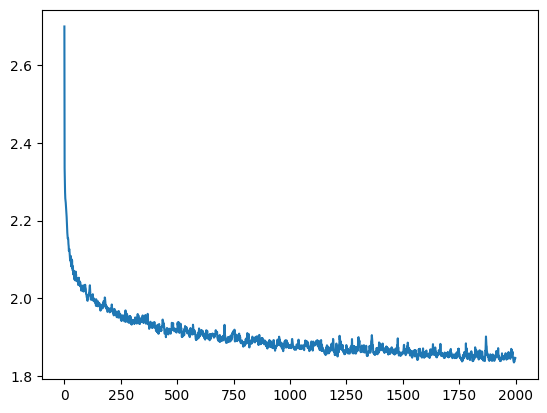

In [276]:
plt.plot(history.losses)

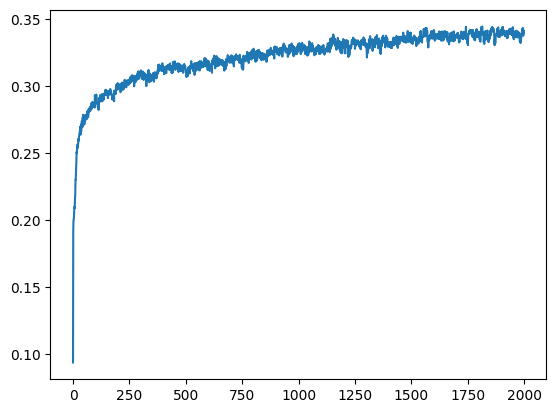

In [277]:
plt.plot(history.train_accuracies)

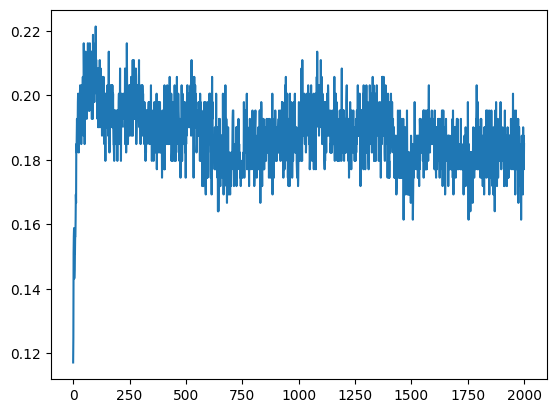

In [278]:
plt.plot(history.val_accuracies)